<a href="https://colab.research.google.com/github/hasanzaki/DeepLearning/blob/main/07_FFNN_CaliforniaHousing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [255]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

import torch.nn.functional as F

In [256]:
# Step 1: Load the dataset
data = fetch_california_housing()
X, y = data.data, data.target # type: ignore

In [257]:
# Convert to DataFrame for visualization
df = pd.DataFrame(X, columns=data.feature_names) # type: ignore
df['Target'] = y

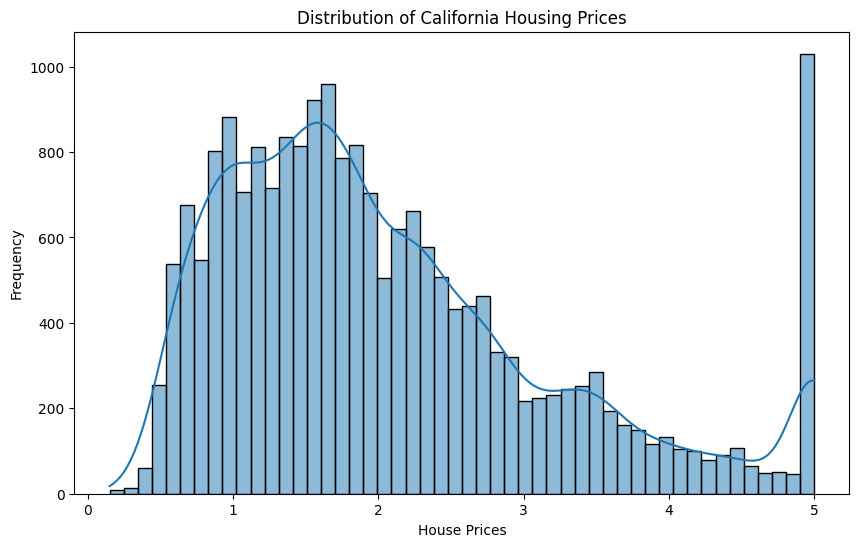

In [258]:
# Step 2: Visualize the dataset
plt.figure(figsize=(10, 6))
sns.histplot(y, bins=50, kde=True)
plt.xlabel('House Prices')
plt.ylabel('Frequency')
plt.title('Distribution of California Housing Prices')
plt.show()

In [259]:
# Step 3: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [260]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, 

((16512, 8), (4128, 8), (16512,), (4128,))

In [261]:
# Step 4: Normalize the data

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [262]:
print(X_train)

[[ 0.19001247 -1.79507596  0.90771428 ...  0.07408222 -0.8400624
   1.00389865]
 [ 0.26931072  1.85553889 -0.04200187 ...  0.04527606  0.98536392
  -1.43477229]
 [ 0.02989505 -0.20785212 -0.30282448 ... -0.03933216 -0.8400624
   0.77948108]
 ...
 [-0.35589721  0.18895385 -0.70992683 ... -0.19238342  0.44709718
  -1.1654712 ]
 [ 0.92053182  0.42703742 -0.35350337 ... -0.12150865 -0.93835459
   0.81439048]
 [-1.30490629 -1.08082523 -0.59566992 ...  0.06298936 -1.32216217
   1.99632302]]


In [263]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [264]:
# # Step 5: Define the FFNN model

# class HousePrice(nn.Module):
#     def __init__(self, in_features=8, h1=100, h2=250, h3=300, out_features=1): 
#         super().__init__()
#         self.fc1 = nn.Linear(in_features,h1)    
#         self.fc2 = nn.Linear(h1, h2)  
#         self.fc3 = nn.Linear(h2, h3)  
#         self.out = nn.Linear(h3, out_features)  
        
#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = F.relu(self.fc3(x))
#         x = self.out(x)
#         return x

In [265]:
class HousePrice(nn.Module):
    def __init__(self, in_features=8, h1=100, h2=250, h3=300, out_features=1): 
        super().__init__()
        self.fc1 = nn.Linear(in_features, h1)    
        self.bn1 = nn.BatchNorm1d(h1)  # Batch normalization for fc1
        self.fc2 = nn.Linear(h1, h2)  
        self.bn2 = nn.BatchNorm1d(h2)  # Batch normalization for fc2
        self.fc3 = nn.Linear(h2, h3)  
        self.bn3 = nn.BatchNorm1d(h3)  # Batch normalization for fc3
        self.out = nn.Linear(h3, out_features)  
        
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), negative_slope=0.01)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.01)
        x = F.leaky_relu(self.fc3(x), negative_slope=0.01)
        x = self.out(x)
        return x

In [266]:
# Step 6: Initialize model, loss, and optimizer

model = HousePrice()
#criterion = nn.CrossEntropyLoss() # Don't Use this, as it is for classification
criterion = nn.MSELoss()           # Use this for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) 

In [267]:
#Step 6: Training the model

epochs = 100 
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    
    # a neat trick to save screen space:
    if i%10 == 1:
        print(f'epoch: {i:2}  loss: {loss.item():10.8f}')

    optimizer.zero_grad() # zero the gradients before running the backward pass.
    loss.backward()
    optimizer.step() # update the weights

epoch:  1  loss: 5.96320915
epoch: 11  loss: 0.59866923
epoch: 21  loss: 0.46630061
epoch: 31  loss: 0.38362992
epoch: 41  loss: 0.36322749
epoch: 51  loss: 0.34760386
epoch: 61  loss: 0.33082056
epoch: 71  loss: 0.31319606
epoch: 81  loss: 0.29863265
epoch: 91  loss: 0.28700423


In [268]:
# Step 9: Evaluate the model

model.eval()
y_pred = model(X_test).detach().numpy()
test_mse = mean_squared_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print(f'Test MSE: {test_mse:.4f}')


Test MSE: 0.2995


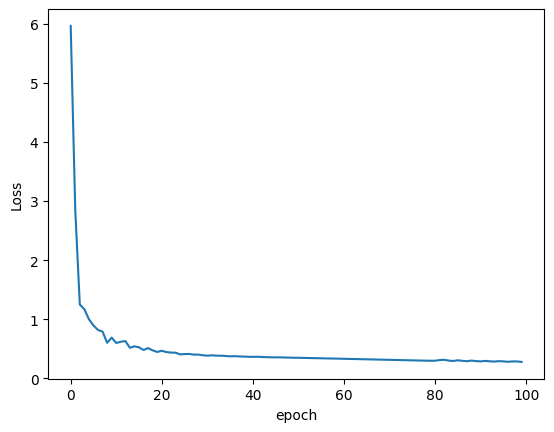

In [269]:
plt.plot(range(epochs), [loss.detach().numpy() for loss in losses])
plt.ylabel('Loss')
plt.xlabel('epoch');

In [270]:
# TO EVALUATE THE ENTIRE TEST SET

with torch.no_grad():
    y_val = model.forward(X_test)
    loss = criterion(y_val, y_test)
print(f'Mean Squared Error (MSE) on Test Set: {loss.item():.8f}')

Mean Squared Error (MSE) on Test Set: 0.29953787


In [271]:
correct = 0
threshold = 0.1  # Define a threshold for correctness (e.g., 10% of the actual value)

predictions = []
actuals = []

with torch.no_grad():
    for i, data in enumerate(X_test):
        y_val = model.forward(data.view(1, -1))
        predictions.append(y_val.item())
        actuals.append(y_test[i].item())
        
        # Check if the prediction is within the threshold
        if abs(y_val.item() - y_test[i].item()) <= threshold * abs(y_test[i].item()):
            correct += 1
        
        print(f'{i+1:2}. Predicted: {y_val.item():.4f}, Actual: {y_test[i].item():.4f}')

print(f'\n{correct} out of {len(y_test)} = {100*correct/len(y_test):.2f}% correct')

 1. Predicted: 1.5051, Actual: 1.3690
 2. Predicted: 2.5756, Actual: 2.4130
 3. Predicted: 1.6153, Actual: 2.0070
 4. Predicted: 0.3217, Actual: 0.7250
 5. Predicted: 3.5597, Actual: 4.6000
 6. Predicted: 2.0379, Actual: 1.2000
 7. Predicted: 2.4277, Actual: 2.4700
 8. Predicted: 3.7367, Actual: 3.3690
 9. Predicted: 3.1113, Actual: 3.3970
10. Predicted: 2.5319, Actual: 2.6560
11. Predicted: 2.4230, Actual: 2.3790
12. Predicted: 1.1703, Actual: 0.9220
13. Predicted: 0.7049, Actual: 0.7950
14. Predicted: 1.9642, Actual: 1.3750
15. Predicted: 2.0540, Actual: 2.2010
16. Predicted: 2.9172, Actual: 2.7610
17. Predicted: 4.0210, Actual: 3.9530
18. Predicted: 2.1139, Actual: 3.0000
19. Predicted: 1.7972, Actual: 1.8270
20. Predicted: 3.8681, Actual: 3.8640
21. Predicted: 1.4115, Actual: 1.3140
22. Predicted: 0.7162, Actual: 0.7420
23. Predicted: 2.2930, Actual: 2.3100
24. Predicted: 2.2389, Actual: 3.9410
25. Predicted: 1.7715, Actual: 1.7610
26. Predicted: 1.9664, Actual: 1.7340
27. Predicte